In [1]:
import matplotlib.pyplot as plt
import numpy as np

from ssfm_functions import wavelengthToFreq, freqToWavelength, wavelengthBWtoFreqBW, freqBWtoWavelengthBW, getGammaFromFiberParams
from scipy.constants import pi, c





# Define Raman Gain function

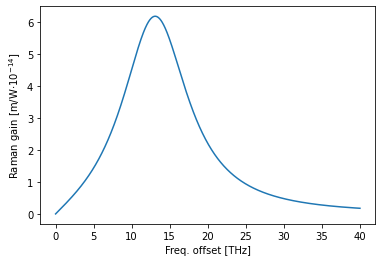

In [2]:

def ramanGainFunction(freq_Hz):
    tau1=12.2*1e-15
    tau2=30.0*1e-15
    a=4.5*1e-14
    return a*np.imag((tau1**2+tau2**2)/(tau1**2*(1-1j*freq_Hz*2*pi*tau2)**2+tau2**2))

fplot=np.linspace(0,40e12,1000)



gR = ramanGainFunction(fplot)

plt.figure()
plt.plot(fplot/1e12,gR/1e-14)
plt.xlabel('Freq. offset [THz]')
plt.ylabel('Raman gain [m/W$\cdot10^{-14}$]')

plt.show()

499.6540966666667 702.2545279925041


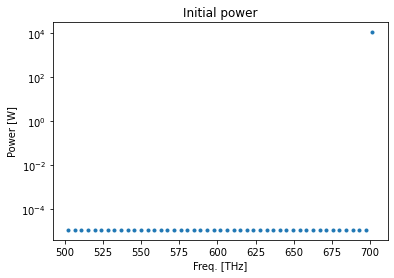

[502.25452799 506.58786133 510.92119466 515.25452799 519.58786133
 523.92119466 528.25452799 532.58786133 536.92119466 541.25452799
 545.58786133 549.92119466 554.25452799 558.58786133 562.92119466
 567.25452799 571.58786133 575.92119466 580.25452799 584.58786133
 588.92119466 593.25452799 597.58786133 601.92119466 606.25452799
 610.58786133 614.92119466 619.25452799 623.58786133 627.92119466
 632.25452799 636.58786133 640.92119466 645.25452799 649.58786133
 653.92119466 658.25452799 662.58786133 666.92119466 671.25452799
 675.58786133 679.92119466 684.25452799 688.58786133 692.92119466
 697.25452799 701.58786133]


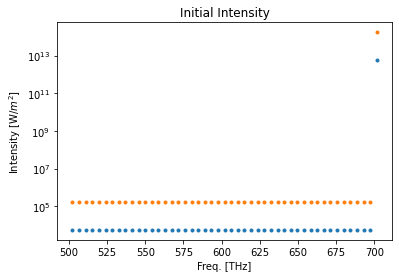

In [49]:
centerWavelength = 426.9e-9 #laser wl in m  
centerFreq = wavelengthToFreq(centerWavelength)
freqList = np.arange(centerFreq-200e12,centerFreq,13/3*1e12)
wavelengthList = freqToWavelength(freqList)

reddestWavelength = 600e-9
reddestFreq = wavelengthToFreq(reddestWavelength)

print(reddestFreq/1e12,centerFreq/1e12 )

P_input = 11.0e3
P0list=np.ones_like(freqList)*P_input*1.0e-9
P0list[-1]=P_input


plt.figure()
plt.title('Initial power')
plt.plot(freqList/1e12,P0list,'.')
plt.yscale('log')
plt.xlabel('Freq. [THz]')
plt.ylabel('Power [W]')
plt.show()

print(freqList/1e12)

n2_silica=2.2e-20 #m**2/W

d_MMF = 50e-6
A_MMF = pi*d_MMF**2/4
gamma_MMF = getGammaFromFiberParams(freqToWavelength(freqList),n2_silica,d_MMF)

d_SMF = 9e-6
A_SMF = pi*d_SMF**2/4
gamma_SMF = getGammaFromFiberParams(freqToWavelength(freqList),n2_silica,d_SMF)

I0_MMF = P0list/A_MMF
I0_SMF = P0list/A_SMF

I0_MMF_plot = np.copy(I0_MMF)

plt.figure()
plt.title('Initial Intensity')
plt.plot(freqList/1e12,I0_MMF,'.')
plt.plot(freqList/1e12,I0_SMF,'.')
plt.yscale('log')
plt.xlabel('Freq. [THz]')
plt.ylabel('Intensity [W/$m^2$]')
plt.show()


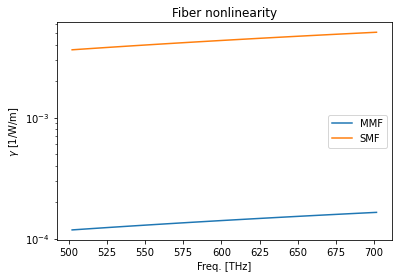

Ratio of gammas = Ratio of Areas =  30.864197530864196


In [48]:


plt.figure()
plt.title('Fiber nonlinearity')
plt.plot(freqList/1e12,gamma_MMF,label='MMF')
plt.plot(freqList/1e12,gamma_SMF,label='SMF')
plt.xlabel('Freq. [THz]')
plt.ylabel('$\gamma$ [1/W/m]')
plt.yscale('log')
plt.legend()
plt.show()
print(f"Ratio of gammas = Ratio of Areas =  {A_MMF/A_SMF}")

In [25]:
N=len(freqList)
gR_matrix = np.zeros( (N,N)  )

for i in range(N):
    for j in range(N):
       gR_matrix[i][j]=ramanGainFunction(freqList[j]-freqList[i] )  
        
        




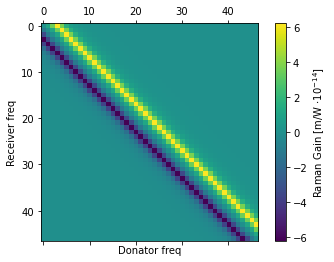

In [26]:


fig,ax=plt.subplots()
surf=ax.matshow(gR_matrix/1e-14)
ax.set_xlabel('Donator freq')
ax.set_ylabel('Receiver freq')
cbar=fig.colorbar(surf, ax=ax)
cbar.set_label('Raman Gain [m/W $\cdot10^{-14}$]')
plt.show()

In [ ]:
def walkoff(f,a):
    a=np.linspace(1/10,0,len(I))
    
    
    

In [129]:
from scipy.integrate import solve_ivp



def dIdz(z,I):
    
    #loss_at_red = 1e-103
    #loss_at_blue = 10e-103
    #freq_range = freqList[-1]-freqList[0]
    #loss_slope = (loss_at_blue-loss_at_red)*freq_range
    
    loss = 0.000575#loss_slope*(freqList-freqList[0])+1
    
    a=np.linspace(1/10,0,len(I))
    
    return (np.dot(gR_matrix,I)*np.exp(-(a.reshape(-1,1)*z)**2)-  loss )*I



z0=0.0
#zmax_SMF = 200.0 #m
zmax_MMF = 25.0 #m

z_steps_MMF = np.linspace(z0,zmax_MMF,100)


sol_MMF=solve_ivp(dIdz,
                  (z0,zmax_MMF),
                  I0_MMF*30,
                  t_eval=z_steps_MMF,
                  method='RK45',
                  vectorized=True,
                  rtol=1e-3,
                  atol=1e-3) 






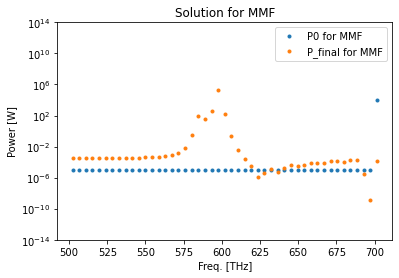

In [130]:
plt.figure()
plt.title("Solution for MMF")
plt.plot(freqList/1e12,I0_MMF_plot*A_MMF,'.',color='C0',label='P0 for MMF')
plt.plot(freqList/1e12,sol_MMF.y[:,-1]*A_MMF,'.',color='C1',label='P_final for MMF')
plt.legend()
plt.xlabel('Freq. [THz]')
plt.ylabel('Power [W]')
plt.yscale('log')
plt.ylim(1e-14,1e14)
plt.show()

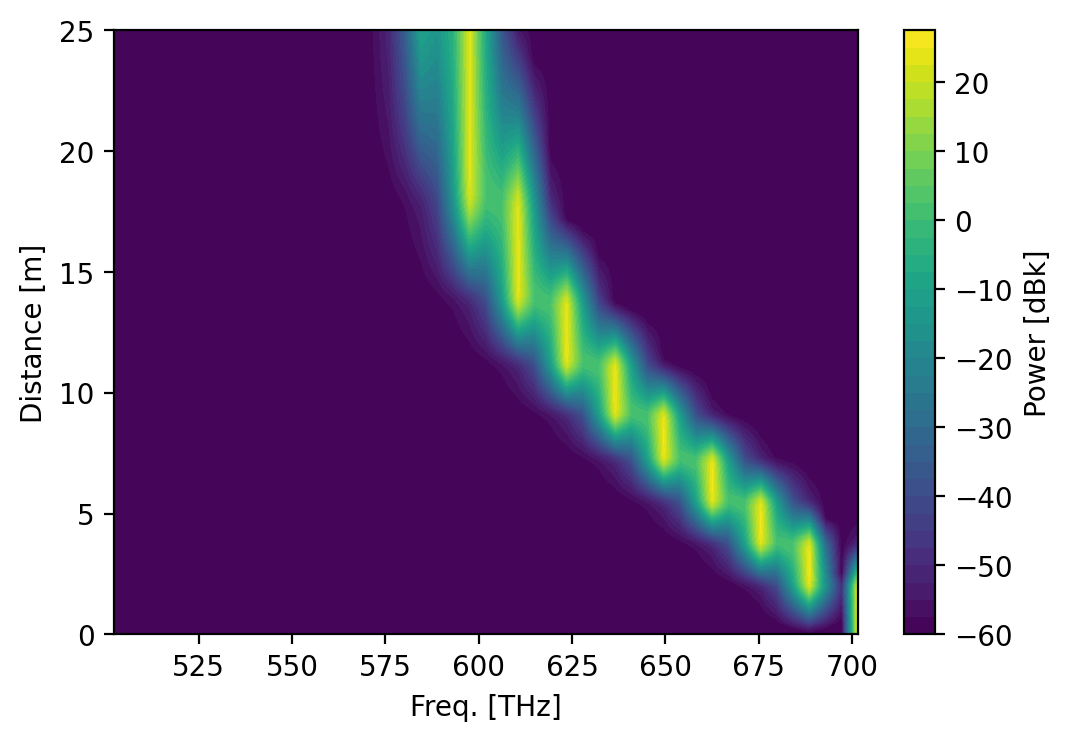

In [132]:
#Make surface plot of solution
fig, ax = plt.subplots(dpi=200)
F, Z = np.meshgrid(freqList/1e12,sol_MMF.t)
P_MMF = 10*np.log10(sol_MMF.y.T*A_MMF/1e3)
P_MMF[ P_MMF<-60 ] = -60
surf=ax.contourf(F, Z, P_MMF,levels=40)
ax.set_xlabel('Freq. [THz]')
ax.set_ylabel('Distance [m]')
cbar=fig.colorbar(surf, ax=ax) 
cbar.set_label('Power [dBk]')
plt.show()